# Imports and Helper functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime

In [2]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  

# 1. Data generator

In [3]:
def occurance(seq, context):
    occ = np.zeros((len(seq), len(context)), dtype=np.uint8)
    counter = np.zeros(len(context))
    
    for i, val in enumerate(seq):
        for e, c in enumerate(context):
            counter[e] += int(c==val)
            occ[i, e] = counter[e]
            
    return occ

def data_generator(time_len=20):
    while True:
        x = np.random.randint(0, 10, time_len)
        context = np.repeat(np.random.randint(0, 10, (1,2)), time_len, axis=0)
        occ = occurance(x, context[0])
        label = np.array([occ[:, 0]>=occ[:, 1], occ[:, 1]>=occ[:, 0]], dtype=np.uint8).T

        # output_shape (time_len, 30), (time_len, 2)
        yield tf.concat([tf.one_hot(context[:, 0], 10), tf.one_hot(x, 10), tf.one_hot(context[:, 1], 10)], axis=-1), tf.constant(label)

In [4]:
batch_size = 64

ds = tf.data.Dataset.from_generator(generator=data_generator,
                                    output_types=(tf.float32, tf.uint8),
                                    # (time_len, 30), (time_len,2)
                                    output_shapes=((None,30), (None,2))
                                    )
ds = ds.batch(batch_size)

# 2. Model

In [5]:
class LSTM_cell(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, input_shape=100):
        super(LSTM_cell, self).__init__()
        self.hidden_dim = hidden_dim
        
        # weight matrices and bias vector shapes        
        output_shape = [self.hidden_dim, 1]
        weight_shape = [self.hidden_dim, input_shape + self.hidden_dim]
        
        # forget gate
        self.w_f = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_f = self.add_weight(shape=output_shape,
                                   # bias of forget gate is initially 1
                                   initializer=tf.keras.initializers.Constant(value=1.0),
                                   trainable=True)
        # input gate
        self.w_i = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_i = self.add_weight(shape=output_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        # candidate layer
        self.w_c = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_c = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        # output gate
        self.w_o = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_o = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
    
    def call(self, x_t, h_t, C_t):
        x_t = tf.expand_dims(x_t, axis=-1)
       
        # concatenate previous hidden_state and current input (shape is 20,1)
        concat = tf.concat([h_t, x_t], axis=1)
        
        # calculate f_t (the forget gate)
        f_t = tf.nn.sigmoid(tf.linalg.matmul(self.w_f, concat) + self.b_f)

        # calculate the input gate i_t
        i_t = tf.nn.sigmoid(tf.linalg.matmul(self.w_i, concat) + self.b_i)
        
        # calculate the Cell state candidates (C_hat)
        C_hat_t = tf.nn.tanh(tf.linalg.matmul(self.w_c, concat) + self.b_c)
                
        # calculate the Cell state (C_t)
        C_t = f_t * C_t + i_t * C_hat_t
        
        # calculate the output state (o_t)
        o_t = tf.nn.sigmoid(tf.linalg.matmul(self.w_o, concat) + self.b_o)
        
        # calculate the new hidden state (h_t)
        h_t = o_t * tf.nn.tanh(C_t)
               
        return h_t, C_t

In [6]:
class LSTM_net(tf.keras.Model):
    '''
    Build a LSTM net with a single recurrent node
    '''
    def __init__(self, hidden_dim=100, readin_units=100):
        super(LSTM_net, self).__init__()

        self.hidden_dim = hidden_dim
        
        self.embedding = tf.keras.layers.Dense(readin_units)
        self.cell = LSTM_cell(hidden_dim=self.hidden_dim, input_shape=readin_units) 
        
        self.out = tf.keras.layers.Dense(2, activation = "sigmoid")
    
    def call(self, x, batch_size):     
        # reset hidden and cell state before each call
        self.hidden_state = tf.zeros((batch_size, self.hidden_dim, 1))
        self.cell_state = tf.ones((batch_size, self.hidden_dim, 1))

        output = [] 
        for i in tf.range(x.shape[-2]):
            x_t = self.embedding(x[:,i,:])
            self.hidden_state, self.cell_state = self.cell(x_t, self.hidden_state, self.cell_state)  
            
            output.append(self.out(tf.reshape(self.hidden_state, (batch_size,1,self.hidden_dim))))

        return tf.concat(output, axis=1)

# 3. Training

In [7]:
# @tf.function
def train_step(model, ds, batch_size, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training for one epoch.
    '''
    
    for seq, target in ds.take(100):
        # forward pass and loss calculation
        with tf.GradientTape() as tape:
            prediction = model(seq, batch_size)
            loss = loss_function(target, prediction)

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

In [8]:
epochs = 25
learning_rate = 0.0005

tf.keras.backend.clear_session()
timer = Timer()

model = LSTM_net(hidden_dim=100, 
                 readin_units=1000)

loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
train_loss_metric = tf.keras.metrics.Mean('train_loss')

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
times = []

In [9]:
print(f'[INFO] - Started training of the {model.name}.')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()
    train_step(model, ds, batch_size, loss_function, optimizer, train_loss_metric, train_acc_metric)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Started training of the lstm_net.

[EPOCH] ____________________0____________________
[0] - Finished Epoch in 11.18 seconds - train_loss: 0.9821, train_acc: 0.5215

[INFO] - Total time elapsed: 0.1864 min. Total time remaining: 4.4730 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 10.95 seconds - train_loss: 0.9746, train_acc: 0.5676

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 10.99 seconds - train_loss: 0.9159, train_acc: 0.6532

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 11.04 seconds - train_loss: 0.7993, train_acc: 0.7507

[INFO] - Total time elapsed: 0.7362 min. Total time remaining: 3.8648 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 11.03 seconds - train_loss: 0.7049, train_acc: 0.7813

[EPOCH] ____________________5____________________
[5] - Finished Epoch in 11.22 seconds - train_loss: 0.6683, train_acc: 0.7927

[EPOCH] ____________________6_

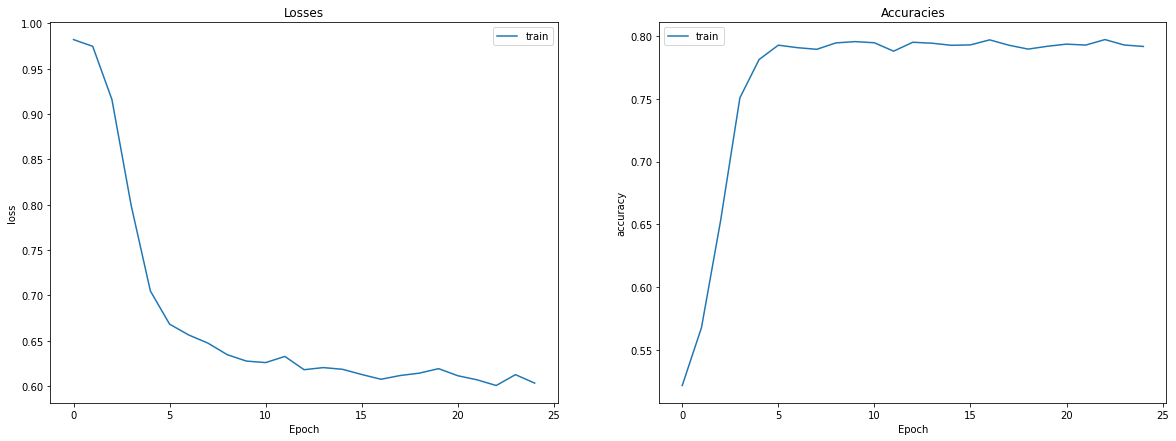

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
# axes[0].plot(x, test_losses, label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
# axes[1].plot(x, test_accuracies, label='test')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()